In [17]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

# Load variables from .env file
load_dotenv()

api_key = os.getenv("ALPHA_VANTAGE_API_KEY")
ts = TimeSeries(key = api_key, output_format = "pandas")

# Defining get asset data variable
def get_asset_data(symbol):
    data, _ = ts.get_daily(symbol = symbol, outputsize = "full")
    data = data[['4. close']] # DF becoems just the close column
    data.columns = [symbol] 
    data.index = pd.to_datetime(data.index) # Converts index from data strings to date/time objects
    return data.sort_index() 


# Get asset data for 3 assets
spy = get_asset_data("SPY")
ief = get_asset_data("IEF")
gld = get_asset_data("GLD")

# Merge into one DataFrame
assets = pd.concat([spy, ief, gld], axis = 1).dropna()

assets.tail()


,SPY,IEF,GLD
date,,,
2025-07-21,628.77,94.73,313.13
2025-07-22,628.86,95.00,316.10
2025-07-23,634.21,94.66,312.18
2025-07-24,634.42,94.52,310.27
2025-07-25,637.10,94.74,307.40


In [4]:
# Calculate 21 day trailing return (trading month)
lookback_days = 21

trailing_returns = assets.pct_change(periods = lookback_days)

trailing_returns.tail()

,SPY,IEF,GLD
date,,,
2025-07-21,0.052440,0.002010,0.009250
2025-07-22,0.058188,0.004228,0.019250
2025-07-23,0.056752,-0.002844,0.003536
2025-07-24,0.045552,-0.007768,0.013325
2025-07-25,0.049381,-0.005876,0.000912


In [8]:
# Implementing rotation signal based on asset with highest 21 day trailing average
rotation_signal = trailing_returns.dropna().idxmax(axis = 1)

rotation_signal.tail()

date
2025-07-21    SPY
2025-07-22    SPY
2025-07-23    SPY
2025-07-24    SPY
2025-07-25    SPY
dtype: object

In [ ]:
# Find daily returns across assets
daily_returns = assets.pct_change().dropna()

# Realign signal to rotate based on previous days asset and reindex
aligned_signal = rotation_signal.shift(1).reindex(daily_returns.index).dropna()

# Calculating the strategy returns based on aligned signal
strategy_returns = []
for date, asset in aligned_signal.items():
    value = daily_returns.loc[date, asset]
    strategy_returns.append(value)

# Indexing strategy_returns as a series
strategy_returns = pd.Series(strategy_returns, index = aligned_signal.index)

strategy_returns.tail()



date
2025-07-21    0.001896
2025-07-22    0.000143
2025-07-23    0.008507
2025-07-24    0.000331
2025-07-25    0.004224
dtype: float64

In [15]:
# Cumulative return of strategy
cum_strategy = (1 + strategy_returns).cumprod()

# Compare to Buy&Hold SPY
cum_spy = (1 + daily_returns["SPY"]).cumprod()

# Compare to equal weighted portfolio
equal_returns = daily_returns[["SPY", "IEF", "GLD"]].mean(axis = 1)
cum_equal = (1 + equal_returns).cumprod()

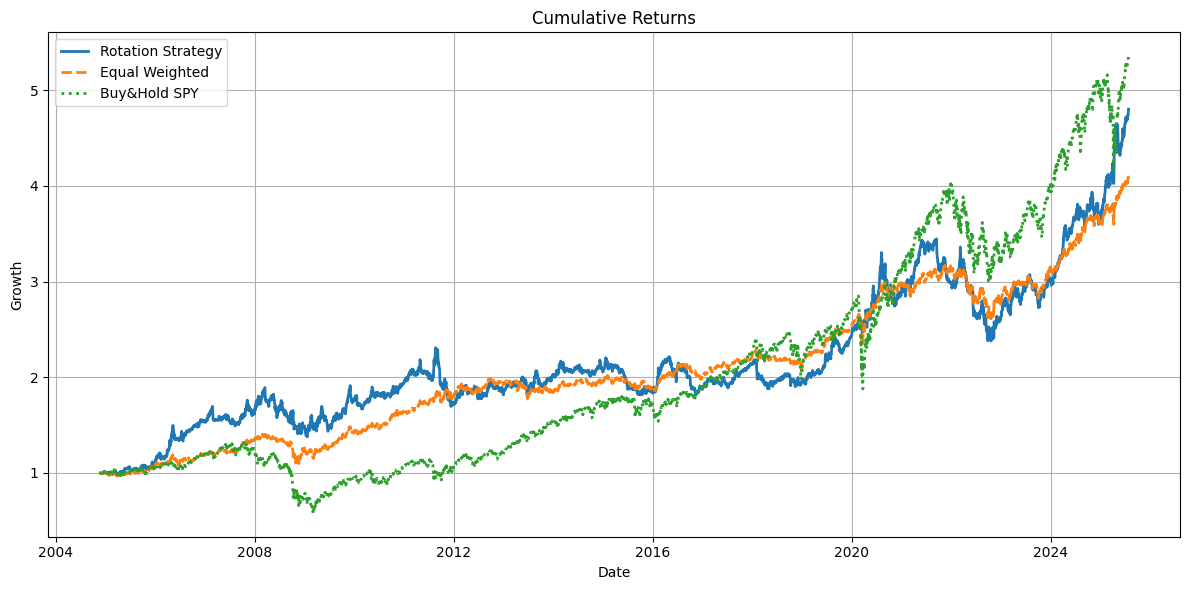

In [18]:
# Plotting Cum Returns of the three strategies
plt.figure(figsize = (12,6))
plt.plot(cum_strategy, label = "Rotation Strategy", linewidth = 2)
plt.plot(cum_equal, label = "Equal Weighted", linestyle = "--", linewidth = 2)
plt.plot(cum_spy, label = "Buy&Hold SPY", linestyle = ":", linewidth = 2)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Growth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()